In [1]:
import jax
import jax.numpy as jnp
from jax import vmap
import optax
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# use float64
from jax.config import config
config.update("jax_enable_x64", True)

# use retina plots
%config InlineBackend.figure_format='retina'

In [3]:
# generate train data
n = 100
noise_sd = 0.4
key = jax.random.PRNGKey(0)
key_x, key_y = jax.random.split(key, 2)
x = jax.random.uniform(key_x, [n, 2])
y = 1 - 2*jax.random.bernoulli(key_y, 0.5, [n]) # {-1, 1}
assert x.dtype == jnp.float64

In [4]:
def kernel_fn(x1, x2, beta):
    return jnp.exp(-beta*((x1[:, None]-x2[None, :])**2).sum(-1))

def predic_fn(x_train, y_train, x_test, beta, gamma):
    n_train = len(x_train)
    K = kernel_fn(x_train, x_train, beta)
    alpha = jnp.linalg.lstsq(K + n_train*gamma, y_train, rcond=None)[0]
    y_hat = kernel_fn(x_test, x_train, beta) @ alpha
    return y_hat

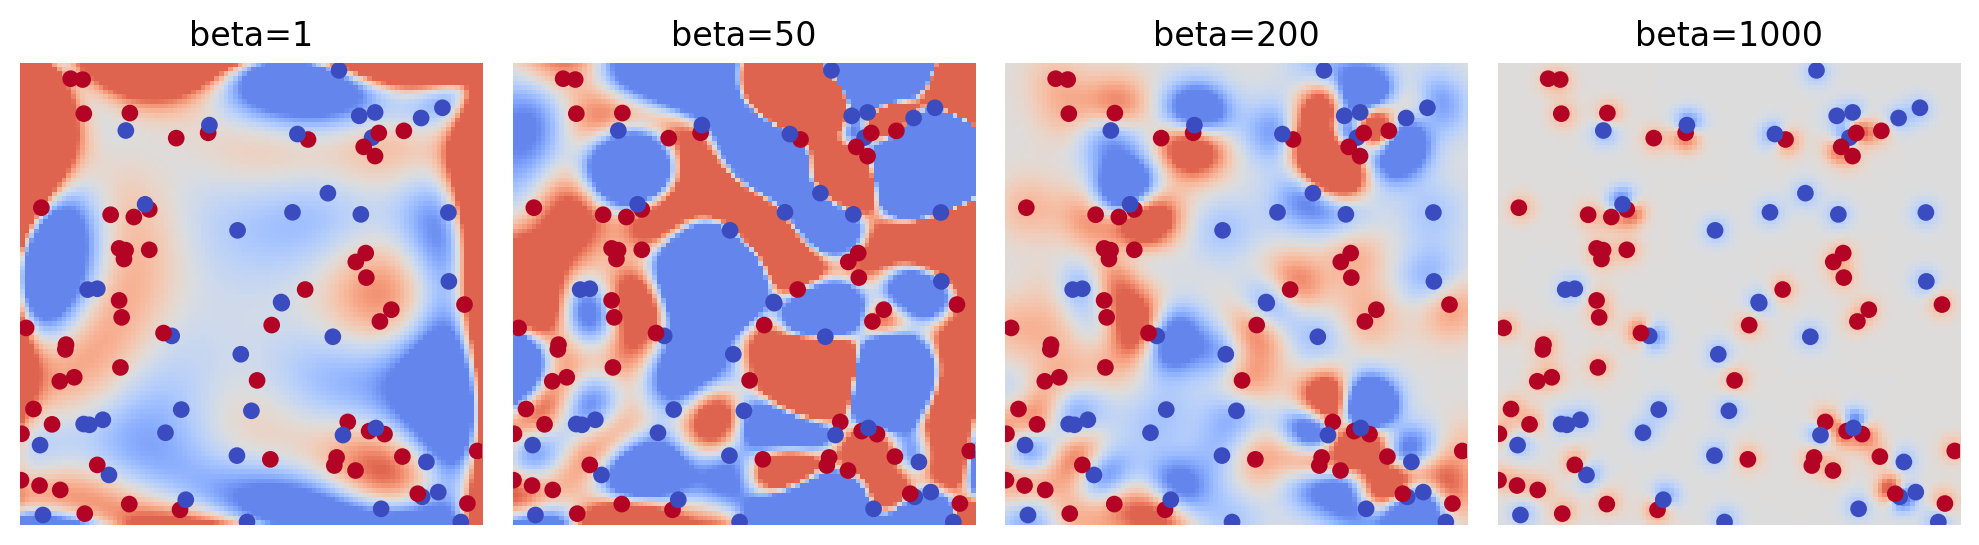

In [5]:
# generate dense grid of points
grid_size = 100
grid_x1 = jnp.linspace(0, 1, grid_size)
grid_x2 = jnp.linspace(0, 1, grid_size)
grid = jnp.stack(jnp.meshgrid(grid_x1, grid_x2), -1) # [grid_size, grid_size, 2]
grid = grid.reshape([grid_size*grid_size, 2])

betas = [1, 50, 200, 1000]
fig, axs = plt.subplots(1, len(betas), figsize=[10, 4])
for ax, beta in zip(axs, betas):

    # run knn on each grid point
    gamma = 1e-20
    grid_y_hat = predic_fn(x, y, grid, beta, gamma)

    # plot
    img = grid_y_hat.reshape([grid_size, grid_size])
    img = img.clip(-2.2, 2.2)
    ax.imshow(img, cmap='coolwarm', extent=[0, 1, 0, 1], vmin=-3, vmax=3, origin='lower')
    ax.scatter(*x.T, c=y, s=25, cmap='coolwarm')
    ax.set_title(f'{beta=}')
    ax.axis('off')

plt.tight_layout()
plt.show()